<a href="https://colab.research.google.com/github/Bergu1/neural-network-project/blob/main/neural_network_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Importuje biblioteke

In [1]:
import torch
import kagglehub

In [2]:
import os

In [3]:
import torchvision.datasets as datasets
import torchvision.transforms as transforms

In [4]:
from sklearn.model_selection import train_test_split
import shutil
from pathlib import Path

In [6]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [7]:
path = kagglehub.dataset_download("chrisfilo/fruit-recognition")
print("Path to dataset files:", path)

100%|██████████| 7.92G/7.92G [01:29<00:00, 95.2MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/chrisfilo/fruit-recognition/versions/1


In [8]:
path = '/root/.cache/kagglehub/datasets/chrisfilo/fruit-recognition/versions/1'
output_path = '/content/banana_kiwi_orange'
os.makedirs(f"{output_path}", exist_ok=True)
output_path = Path(output_path)
output_path

PosixPath('/content/banana_kiwi_orange')

In [9]:
files = os.listdir(path)
print("Files in the dataset folder:", files)

Files in the dataset folder: ['Pear', 'muskmelon', 'Tomatoes', 'Plum', 'Pomegranate', 'Guava', 'Banana', 'Kiwi', 'Pitaya', 'Orange', 'Apple', 'Persimmon', 'Peach', 'Mango', 'Carambola']


#Usuwanie folderów

In [ ]:
for item in os.listdir(output_path):
    item_path = os.path.join(output_path, item)
    if os.path.isdir(item_path):
        shutil.rmtree(item_path)

# Pobieranie danych i kopiowanie do konkretnych utworzonych przez nas folderów
w poniższym przypadku mamy tylko podział na test i train gdybyśmy chcieli mieć podział na test train i validation należało by to zrobić tak:

Najpierw dzielimy dane na zestaw treningowy oraz pozostały (test + walidacja):

**train_images, remaining_images = train_test_split(images, train_size=train_size, random_state=42)**

Następnie dzielimy pozostały zbiór na test i walidację:

**test_images, validation_images = train_test_split(remaining_images, test_size=validation_size, random_state=42)**

Do tych folderów przypisywane są same nazwy obrazków na podstawie których będziemy kopiować dane z datasetu.

In [10]:
categories = ['banana', 'peach', 'orange']
train_size = 800
test_size = 200

In [11]:
os.makedirs(f"{output_path}/train", exist_ok=True)
os.makedirs(f"{output_path}/test", exist_ok=True)

In [12]:
for category in categories:
  category_path = os.path.join(path, category.capitalize())
  train_category_path = os.path.join(output_path, 'train', category)
  test_category_path = os.path.join(output_path, 'test', category)

  os.makedirs(train_category_path, exist_ok=True)
  os.makedirs(test_category_path, exist_ok=True)

  images = os.listdir(category_path)
  train_images, test_images = train_test_split(images, train_size=train_size, test_size=test_size, random_state=42)

  for img in train_images:
      shutil.copy(os.path.join(category_path, img), os.path.join(train_category_path, img))

  for img in test_images:
      shutil.copy(os.path.join(category_path, img), os.path.join(test_category_path, img))

In [13]:
import random
from PIL import Image

In [14]:
random.seed(42)

image_path_list = list(output_path.glob("*/*/*.png"))

Random image path: /content/banana_kiwi_orange/train/banana/Banana0821.png
Image class: banana
Image height: 258
Image width: 320


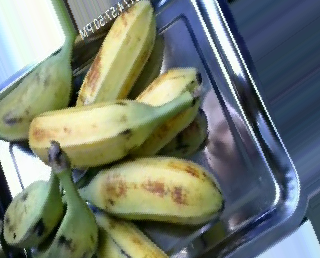

In [15]:
random_image_path = random.choice(image_path_list)

image_class = random_image_path.parent.stem

img = Image.open(random_image_path)

print(f"Random image path: {random_image_path}")
print(f"Image class: {image_class}")
print(f"Image height: {img.height}")
print(f"Image width: {img.width}")
img

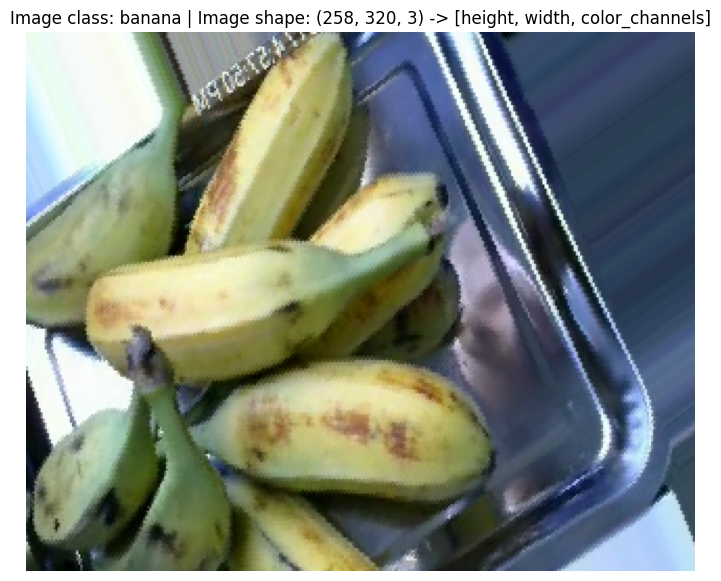

In [16]:
import numpy as np
import matplotlib.pyplot as plt

img_as_array = np.asarray(img)

plt.figure(figsize=(10, 7))
plt.imshow(img_as_array)
plt.title(f"Image class: {image_class} | Image shape: {img_as_array.shape} -> [height, width, color_channels]")
plt.axis(False);

In [17]:
from torch.utils.data import DataLoader

In [18]:
data_transform = transforms.Compose([
    # zmiana rozmiaru obrazu na 64x64
    transforms.Resize(size=(64, 64)),
    # Losowy obrót obrazu
    transforms.RandomHorizontalFlip(p=0.5), # prawdopodobieństwo obrotu 50%
    # Przekształcenie obrazu w tensor
    transforms.ToTensor()
])

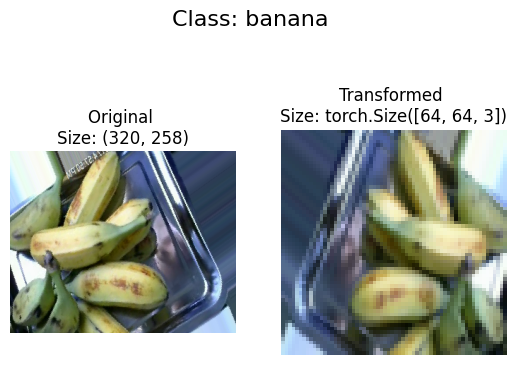

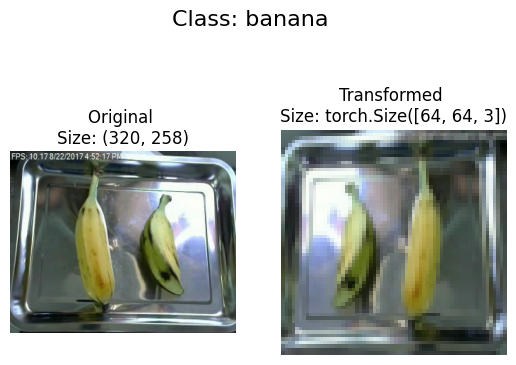

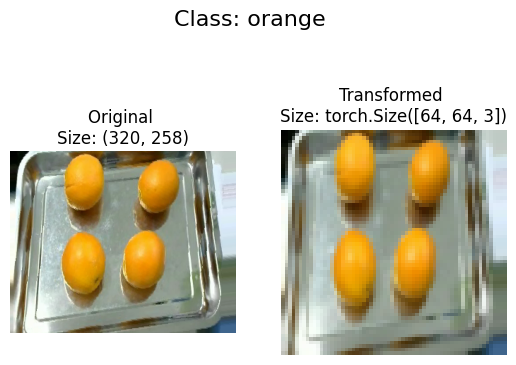

In [19]:
def plot_transformed_images(image_paths, transform, n=3, seed=42):
    random.seed(seed)
    # losujemy trzy losowe obrazki
    random_image_paths = random.sample(image_paths, k=n)
    for image_path in random_image_paths:
        # każdy z obrazków otwieramy jako f
        with Image.open(image_path) as f:
            fig, ax = plt.subplots(1, 2)
            ax[0].imshow(f)
            ax[0].set_title(f"Original \nSize: {f.size}")
            ax[0].axis("off")

            # każdy obrazek przekształcamy w tensor a następnie zamieniamy kolejność channeli w pytorchu
            # jest colour high i width a my chcemy high width colour
            transformed_image = transform(f).permute(1, 2, 0)
            ax[1].imshow(transformed_image)
            ax[1].set_title(f"Transformed \nSize: {transformed_image.shape}")
            ax[1].axis("off")

            fig.suptitle(f"Class: {image_path.parent.stem}", fontsize=16)

plot_transformed_images(image_path_list,
                        transform=data_transform,
                        n=3)

In [20]:
def plot_transformed_images(image_paths, transform, seed=42):
    random.seed(seed)
    for image_path in image_paths:
        with Image.open(image_path) as f:
            transform(f).permute(1, 2, 0)

plot_transformed_images(image_path_list,
                        transform=data_transform)

#  Lepsze rozbudowanie zmian obrazków na tensory by lepiej nauczyć naszą sieć

In [85]:
from torchvision import transforms

train_transforms = transforms.Compose([
    transforms.Resize((64, 64)),
    # transforms.TrivialAugmentWide(num_magnitude_bins=31),
    transforms.ToTensor()
])


test_transforms = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor()
])

# Zmiana obrazków w DataSet

In [86]:
from torchvision import datasets
train_data = datasets.ImageFolder(root=output_path / "train",
                                  transform=train_transforms,
                                  target_transform=None)

test_data = datasets.ImageFolder(root=output_path / "test",
                                 transform=test_transforms)

print(f"Train data:\n{train_data}\nTest data:\n{test_data}")

Train data:
Dataset ImageFolder
    Number of datapoints: 2400
    Root location: /content/banana_kiwi_orange/train
    StandardTransform
Transform: Compose(
               Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
               ToTensor()
           )
Test data:
Dataset ImageFolder
    Number of datapoints: 600
    Root location: /content/banana_kiwi_orange/test
    StandardTransform
Transform: Compose(
               Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
               ToTensor()
           )


In [87]:
# Otrzymanie klas jako lisa
class_names = train_data.classes
class_names

['banana', 'orange', 'peach']

In [88]:
# Otrzymanie klas jako slownik
class_dict = train_data.class_to_idx
class_dict

{'banana': 0, 'orange': 1, 'peach': 2}

In [89]:
len(train_data), len(test_data)

(2400, 600)

In [90]:
img, label = train_data[2300][0], train_data[2300][1]
print(f"Image tensor:\n{img}")
print(f"Image shape: {img.shape}")
print(f"Image datatype: {img.dtype}")
print(f"Image label: {label}")
print(f"Label datatype: {type(label)}")

Image tensor:
tensor([[[0.4980, 0.5216, 0.5176,  ..., 0.2196, 0.1686, 0.2314],
         [0.5804, 0.6078, 0.5843,  ..., 0.2078, 0.1922, 0.2196],
         [0.4863, 0.4863, 0.4314,  ..., 0.2392, 0.2275, 0.2863],
         ...,
         [0.5059, 0.4157, 0.3961,  ..., 0.9608, 0.9647, 0.9647],
         [0.4235, 0.4745, 0.4353,  ..., 0.9765, 0.9804, 0.9765],
         [0.4039, 0.4314, 0.4627,  ..., 0.8392, 0.8157, 0.7843]],

        [[0.5216, 0.5490, 0.5412,  ..., 0.2118, 0.1922, 0.2627],
         [0.6039, 0.6353, 0.6118,  ..., 0.2196, 0.2196, 0.2510],
         [0.5098, 0.5137, 0.4667,  ..., 0.2627, 0.2588, 0.3137],
         ...,
         [0.5373, 0.4431, 0.4157,  ..., 0.9765, 0.9765, 0.9765],
         [0.4667, 0.5137, 0.4706,  ..., 0.9922, 0.9922, 0.9882],
         [0.4471, 0.4667, 0.4863,  ..., 0.8549, 0.8314, 0.8000]],

        [[0.5137, 0.5412, 0.5333,  ..., 0.1647, 0.1686, 0.2431],
         [0.5961, 0.6275, 0.6039,  ..., 0.1922, 0.2039, 0.2314],
         [0.5020, 0.5098, 0.4549,  ..., 0.24

Original shape: torch.Size([3, 64, 64]) -> [color_channels, height, width]
Image permute shape: torch.Size([64, 64, 3]) -> [height, width, color_channels]


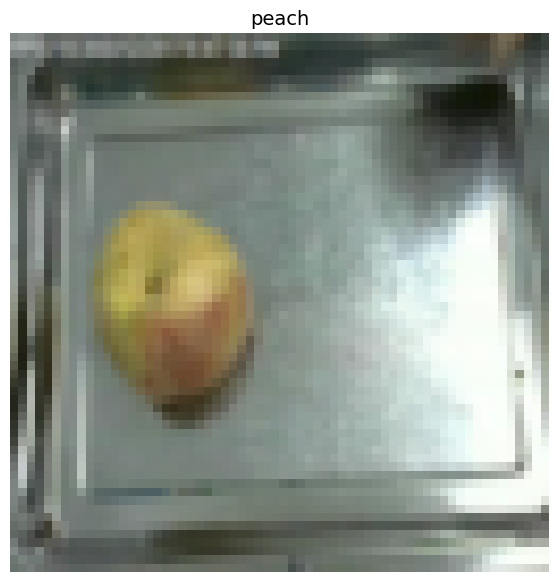

In [91]:
img_permute = img.permute(1, 2, 0)

# Print out different shapes (before and after permute)
print(f"Original shape: {img.shape} -> [color_channels, height, width]")
print(f"Image permute shape: {img_permute.shape} -> [height, width, color_channels]")

plt.figure(figsize=(10, 7))
plt.imshow(img.permute(1, 2, 0))
plt.axis("off")
plt.title(class_names[label], fontsize=14);

# Zmiana obrazka w Dataloader


In [92]:
from torch.utils.data import DataLoader
BATCH_SIZE = 32
train_dataloader = DataLoader(dataset=train_data,
                              batch_size=BATCH_SIZE,
                              num_workers=os.cpu_count(),
                              shuffle=True)

test_dataloader = DataLoader(dataset=test_data,
                             batch_size=BATCH_SIZE,
                             num_workers=os.cpu_count(),
                             shuffle=False)

train_dataloader, test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x7866b2b43be0>,
 <torch.utils.data.dataloader.DataLoader at 0x7866b2b438e0>)

In [93]:
img, label = next(iter(train_dataloader))

print(f"Image shape: {img.shape} -> [batch_size, color_channels, height, width]")
print(f"Label shape: {label.shape}")

Image shape: torch.Size([32, 3, 64, 64]) -> [batch_size, color_channels, height, width]
Label shape: torch.Size([32])


#TinyVGG model

In [94]:
from torch import nn

In [95]:
device = "cuda"

In [96]:
class FruitRecognitionModel(nn.Module):
  def __init__ (self, input_shape: int, hidden_units: int, output_shape: int) -> None:
      super().__init__()
      self.conv_block_1 = nn.Sequential(
          nn.Conv2d(in_channels=input_shape,
                    out_channels=hidden_units,
                    kernel_size=3, # okienko 3 na 3 przejścia przez pixele
                    stride=1, # co ile pixeli przechodzisz
                    padding=0, # obramówka obrazu
                    ),
          nn.ReLU(),
          nn.Conv2d(in_channels=hidden_units,
                    out_channels=hidden_units,
                    kernel_size=3,
                    stride=1,
                    padding=0),
          nn.ReLU(),
          nn.MaxPool2d(kernel_size=2,
                      stride=2),
      )
      self.conv_block_2 = nn.Sequential(
          nn.Conv2d(hidden_units, hidden_units, kernel_size=3, padding=0),
          nn.ReLU(),
          nn.Conv2d(hidden_units, hidden_units, kernel_size=3, padding=0),
          nn.ReLU(),
          nn.MaxPool2d(2)
          )
      self.classifier = nn.Sequential(
          nn.Flatten(),
          # Where did this in_features shape come from?
          # It's because each layer of our network compresses and changes the shape of our input data.
          nn.Linear(in_features=hidden_units*13*13,
                    out_features=output_shape)
          )

  def forward(self, x: torch.Tensor):
    x = self.conv_block_1(x)
    x = self.conv_block_2(x)
    x = self.classifier(x)
    return x

torch.manual_seed(42)
model_0 = FruitRecognitionModel(input_shape=3, # number of color channels (3 for RGB)
                  hidden_units=10,
                  output_shape=len(train_data.classes)).to(device)
model_0

FruitRecognitionModel(
  (conv_block_1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=1690, out_features=3, bias=True)
  )
)

In [97]:
img_batch, label_batch = next(iter(train_dataloader))

img_single, label_single = img_batch[0].unsqueeze(dim=0), label_batch[0]
print(f"Single image shape: {img_single.shape}\n")

model_0.eval()
with torch.inference_mode():
    pred = model_0(img_single.to(device))

print(f"Output logits:\n{pred}\n")
print(f"Output prediction probabilities:\n{torch.softmax(pred, dim=1)}\n")
print(f"Output prediction label:\n{torch.argmax(torch.softmax(pred, dim=1), dim=1)}\n")
print(f"Actual label:\n{label_single}")

Single image shape: torch.Size([1, 3, 64, 64])

Output logits:
tensor([[0.0216, 0.0002, 0.0089]], device='cuda:0')

Output prediction probabilities:
tensor([[0.3371, 0.3300, 0.3329]], device='cuda:0')

Output prediction label:
tensor([0], device='cuda:0')

Actual label:
2


In [98]:
try:
    import torchinfo
except:
    !pip install torchinfo
    import torchinfo

from torchinfo import summary
summary(model_0, input_size=[1, 3, 64, 64])

Layer (type:depth-idx)                   Output Shape              Param #
FruitRecognitionModel                    [1, 3]                    --
├─Sequential: 1-1                        [1, 10, 30, 30]           --
│    └─Conv2d: 2-1                       [1, 10, 62, 62]           280
│    └─ReLU: 2-2                         [1, 10, 62, 62]           --
│    └─Conv2d: 2-3                       [1, 10, 60, 60]           910
│    └─ReLU: 2-4                         [1, 10, 60, 60]           --
│    └─MaxPool2d: 2-5                    [1, 10, 30, 30]           --
├─Sequential: 1-2                        [1, 10, 13, 13]           --
│    └─Conv2d: 2-6                       [1, 10, 28, 28]           910
│    └─ReLU: 2-7                         [1, 10, 28, 28]           --
│    └─Conv2d: 2-8                       [1, 10, 26, 26]           910
│    └─ReLU: 2-9                         [1, 10, 26, 26]           --
│    └─MaxPool2d: 2-10                   [1, 10, 13, 13]           --
├─Sequentia

In [99]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_0.parameters(), lr=0.001)

In [100]:
def train_step(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer):

    # Put model in train mode
    model.train()

    train_loss, train_acc = 0, 0

    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        y_pred = model(X)

        loss = loss_fn(y_pred, y)
        train_loss += loss.item()

        optimizer.zero_grad()

        loss.backward()

        optimizer.step()

        y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
        train_acc += (y_pred_class == y).sum().item()/len(y_pred)

    train_loss = train_loss / len(dataloader)
    train_acc = train_acc / len(dataloader)
    return train_loss, train_acc

for train in range(10):
  train_loss, train_acc = train_step(model_0, train_dataloader, loss_fn, optimizer)
  print(f"Epoch: {train} Loss {train_loss} Accuracy: {train_acc}")


Epoch: 0 Loss 0.9850687114397685 Accuracy: 0.46708333333333335
Epoch: 1 Loss 0.3479021119078 Accuracy: 0.845
Epoch: 2 Loss 0.09889189371839166 Accuracy: 0.96625
Epoch: 3 Loss 0.041572916920607286 Accuracy: 0.98875
Epoch: 4 Loss 0.05806604319019243 Accuracy: 0.98375
Epoch: 5 Loss 0.10409759402895967 Accuracy: 0.97
Epoch: 6 Loss 0.02440805159819623 Accuracy: 0.99375
Epoch: 7 Loss 0.020554808739107103 Accuracy: 0.9954166666666666
Epoch: 8 Loss 0.028662376582700138 Accuracy: 0.9908333333333333
Epoch: 9 Loss 0.012558642356501271 Accuracy: 0.9970833333333333


In [103]:
def test_step(model: torch.nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module):

    model.eval()

    test_loss, test_acc = 0, 0

    with torch.inference_mode():
        for batch, (X, y) in enumerate(dataloader):
            X, y = X.to(device), y.to(device)

            test_pred_logits = model(X)

            loss = loss_fn(test_pred_logits, y)
            test_loss += loss.item()

            test_pred_labels = test_pred_logits.argmax(dim=1)
            test_acc += ((test_pred_labels == y).sum().item()/len(test_pred_labels))

    test_loss = test_loss / len(dataloader)
    test_acc = test_acc / len(dataloader)
    return test_loss, test_acc


test_loss, test_acc = test_step(model_0, train_dataloader, loss_fn)
print(f"Loss {test_loss} Accuracy: {test_acc}")

Loss 0.023123106081038715 Accuracy: 0.9945833333333334
